In [1]:
import os
import numpy as np
from PIL import Image, ImageFile
from skimage import io
import matplotlib.pyplot as plt
import tifffile
from scipy import misc
from tifffile import TiffFile
from tifffile.tifffile import TIFF_DECOMPESSORS
from visualization import ids_to_greyscale, load_depth, show_bounding_boxes, load_stencil_ids, load_stencil_flags, \
get_bounding_boxes, show_loaded_bounding_boxes, get_detections

In [2]:
import visualization
visualization.multi_page = False
visualization.ini_file = 'gta-postprocessing.local.ini'

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, cam_near_clip, cam_far_clip, timestamp, view_matrix, proj_matrix, world_matrix, 
    width, height, \
    ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as relative_cam_rot, \
    ARRAY[st_x(camera_pos), st_y(camera_pos), st_z(camera_pos)] as camera_pos \
    FROM snapshots \
    ORDER BY snapshot_id DESC \
    LIMIT 1 \
    OFFSET 3 \
    """)

results = [dict(res) for res in cur]
for i, res in enumerate(results):
    res['view_matrix'] = np.array(res['view_matrix'])
    res['proj_matrix'] = np.array(res['proj_matrix'])
    res['world_matrix'] = np.array(res['world_matrix'])
    res['camera_pos'] = np.array(res['camera_pos'])
    results[i] = res

res = results[0]
name = res['imagepath']
print(name)

2018-02-26--12-37-27--791


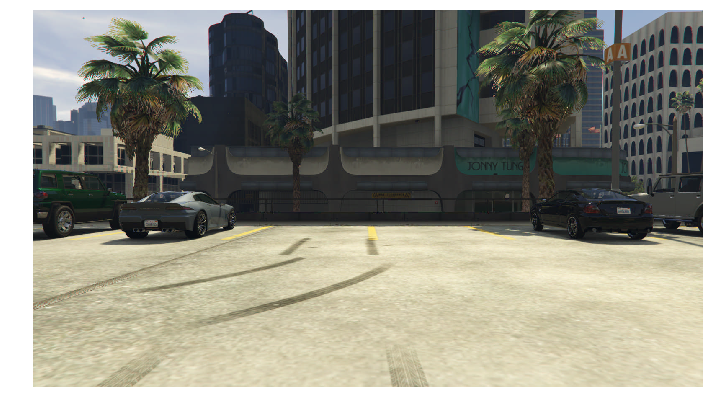

In [3]:
%matplotlib inline
im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
fig = plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(im)
plt.show()

In [14]:
detections = get_detections(name)
print('total detections: {}'.format(len(detections)))
detections = [d for d in detections if np.linalg.norm(res['camera_pos'] - d['pos']) < 16]
print('near detections: {}'.format(len(detections)))

total detections: 264
near detections: 4


In [15]:
for d in detections:
    print('pos: {}, type: {}, class: {}, handle: {}, dist. {}'.format(d['pos'], d['type'], d['class'], d['handle'], np.linalg.norm(res['camera_pos'] - d['pos'])))


pos: [-915.16723633 -166.42643738   41.78274536], type: car, class: SUVs, handle: 54786, dist. 14.991173686271242
pos: [-918.58288574 -168.01574707   41.17297363], type: car, class: Sports, handle: 55298, dist. 12.984080732980885
pos: [-928.8694458  -172.87759399   41.44162369], type: car, class: Compacts, handle: 56066, dist. 13.075167319940302
pos: [-931.83740234 -175.00697327   41.38191986], type: car, class: SUVs, handle: 56578, dist. 15.539587547071184


In [16]:
l_car = detections[0]
r_car = detections[3]

In [19]:
width = res['width']
height = res['height']
size = (height, width)
near_clip = res['cam_near_clip']
far_clip = res['cam_far_clip']

view_matrix = res['view_matrix']
proj_matrix = res['proj_matrix']
l_vec_pos = l_car['pos']
r_vec_pos = r_car['pos']
l_vec = np.array([l_vec_pos[0], l_vec_pos[1], l_vec_pos[2], 1])
r_vec = np.array([r_vec_pos[0], r_vec_pos[1], r_vec_pos[2], 1])

print('original points')
print(l_vec)
print(r_vec)

l_vec_camera = view_matrix @ l_vec
r_vec_camera = view_matrix @ r_vec
l_vec_camera /= l_vec_camera[3]
r_vec_camera /= r_vec_camera[3]

print('camera points')
print(l_vec_camera)
print(r_vec_camera)

l_vec_ndc = proj_matrix @ l_vec_camera
r_vec_ndc = proj_matrix @ r_vec_camera
l_vec_ndc /= l_vec_ndc[3]
r_vec_ndc /= r_vec_ndc[3]

print('projected points')
print(l_vec_ndc)
print(r_vec_ndc)


original points
[-915.16723633 -166.42643738   41.78274536    1.        ]
[-931.83740234 -175.00697327   41.38191986    1.        ]
camera points
[ -9.03751453  -0.11770775 -11.96013465   1.        ]
[  9.7106667   -0.51841532 -12.12076737   1.        ]
projected points
[-0.91151309 -0.02110547  0.12528549  1.        ]
[ 0.96642665 -0.09172228  0.12362313  1.        ]


In [26]:
def pixel_to_normalized(pixel, size):
    p_y, p_x = pixel
    s_y, s_x = size
    return ((2/s_y)*p_y - 1, (2/s_x)*p_x - 1)

def normalized_to_pixel(pixel, size):
    p_y, p_x = pixel
    s_y, s_x = size
    return ((s_y/2)*p_y + (s_y/2), (s_x/2)*p_x + (s_x/2))

In [27]:
l_vec_point = normalized_to_pixel((l_vec_ndc[1], l_vec_ndc[0]), size)
r_vec_point = normalized_to_pixel((r_vec_ndc[1], r_vec_ndc[0]), size)

print('projected points')
print(l_vec_point)
print(r_vec_point)


projected points
(440.50253705125618, 70.789527364885657)
(408.72497199667691, 1573.141318453142)


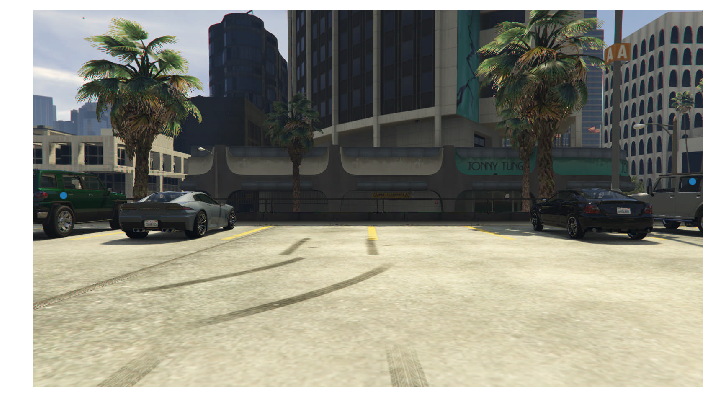

In [28]:
%matplotlib inline
im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
fig = plt.figure(figsize=(12,12))
plt.axis('off')
plt.plot([l_vec_point[1], r_vec_point[1]], [l_vec_point[0], r_vec_point[0]], 'o')
plt.imshow(im)
plt.show()

### mapping all 4 cars

In [48]:
vecs_pos = [d['pos'] for d in detections]
vecs = np.array([[vec[0], vec[1], vec[2], 1] for vec in vecs_pos]).T

width = res['width']
height = res['height']
size = (height, width)
near_clip = res['cam_near_clip']
far_clip = res['cam_far_clip']

view_matrix = res['view_matrix']
proj_matrix = res['proj_matrix']

print('original points')
print(vecs)

vecs_camera = view_matrix @ vecs
vecs_camera /= vecs_camera[3, :]

print('camera points')
print(vecs_camera)

vecs_ndc = proj_matrix @ vecs_camera
vecs_ndc /= vecs_ndc[3, :]

print('projected points')
print(vecs_ndc)

points = []
for vec in vecs_ndc.T:
    points.append(normalized_to_pixel((vec[1], vec[0]), size))
points = np.array(points)
points = points.astype(int)
    
print('pixel points')
print(points)


original points
[[-915.16723633 -918.58288574 -928.8694458  -931.83740234]
 [-166.42643738 -168.01574707 -172.87759399 -175.00697327]
 [  41.78274536   41.17297363   41.44162369   41.38191986]
 [   1.            1.            1.            1.        ]]
camera points
[[ -9.03751453  -5.27206548   6.10194165   9.7106667 ]
 [ -0.11770775  -0.72771946  -0.45967674  -0.51841532]
 [-11.96013465 -11.84323242 -11.55487068 -12.12076737]
 [  1.           1.           1.           1.        ]]
projected points
[[-0.91151309 -0.53698297  0.63701979  0.96642665]
 [-0.02110547 -0.13177135 -0.08531287 -0.09172228]
 [ 0.12528549  0.12652364  0.12968489  0.12362313]
 [ 1.          1.          1.          1.        ]]
pixel points
[[ 440   70]
 [ 390  370]
 [ 411 1309]
 [ 408 1573]]


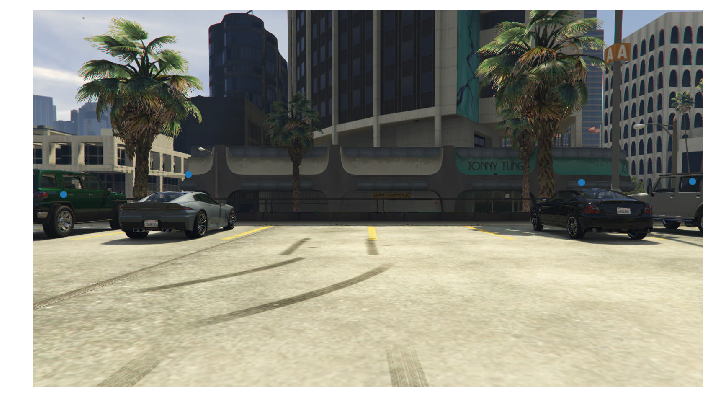

In [49]:
%matplotlib inline
im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
fig = plt.figure(figsize=(12,12))
plt.axis('off')
plt.plot(points[:, 1], points[:, 0], 'o')
plt.imshow(im)
plt.show()

In [50]:
depth = load_depth(name)
print("depth points")
print("expected:")
print(vecs_ndc[2, :])
print("real:")
print(depth[(points[:, 0], points[:, 1])])

depth points
expected:
[ 0.12528549  0.12652364  0.12968489  0.12362313]
real:
[ 0.14186959  0.025672    0.03653035  0.13233538]


<IPython.core.display.Javascript object>


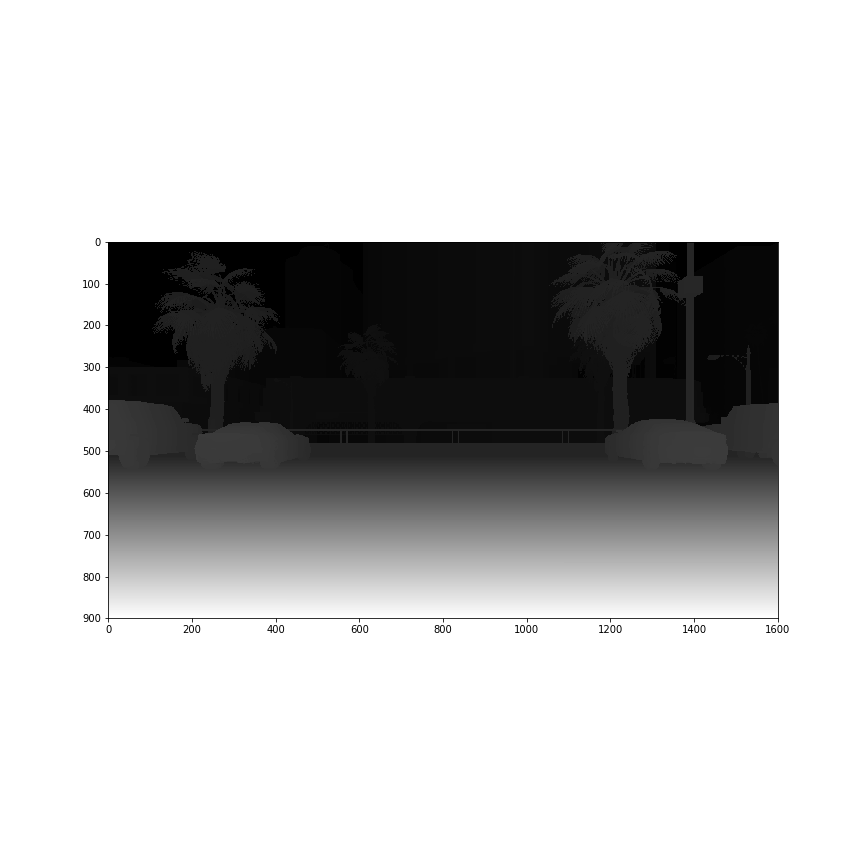

In [70]:
%matplotlib notebook
depth = load_depth(name)
fig = plt.figure(figsize=(12,12))
plt.axis('on')
plt.imshow(depth, cmap='gray')